#### AUTOMATIC DOMAIN DECOMPOSITION VISCID BURGERS EQUATION 1D
Let $\Omega = (-1 , 1)^2$ and $\nu > 0 $:

$$
    \begin{cases}
        u_t + u u_{x} - \nu u_{xx} &= 0, \text{ in } \Omega,\\
        u(0, x) &= -\sin(\pi x) \text{ in } (-1, 1),\\
        u(t, -1) = u(t, 1) &= 0 \text{ in } (0, 1).
    \end{cases}
$$

#### PDE DATA
$$
    \begin{split}
        g(x,t) &= \left[ -\int_{-\infty}^{+\infty} \sin(\pi(x-\eta)) f(x-\eta) \exp\left(-\frac{\eta^2}{4\nu t}\right) d \eta \middle/ \int_{-\infty}^{+\infty} f(x-\eta) \exp\left(-\frac{\eta^2}{4\nu t}\right) d \eta \right]\\
        f(y) &= \exp \left[-\frac{\cos(\pi y)}{2 \pi \nu}\right]
    \end{split}
$$

#### EXPERIMENTS
Experiment 1: $\nu = 0.01$, $p=\infty$, $I_0 =\{-1, -0.6, -0.2,  0.2,  0.6,  1\}$;

Experiment 2: $\nu = 0.01$, $p=2$, $I_0 =\{-1, -0.6, -0.2, 0.2, 0.6,  1\}$;

In [1]:
import numpy as np
import sys
import json
import torch
import scipy as sp
sys.path.insert(1, 'C:/Users/philh/Notebooks/thesis_framework/')
from differentiation import Differentiation
from cubature import Cubature
from benchmark import Benchmark
from utilities import matmul, data_axes, leg_bary, laplacian, inverse_lu, mui_lp_ext, cart, pullback, hyper_rect,\
implicit_euler, L, prepare, extract_models
torch.set_default_dtype(torch.float64)
prefix = None#"viscid_burgers_equation"

#### CUBATURE AND DIFFERENTIATION

In [2]:
#  X-PARTITION #
ints_0 = np.linspace(-1.0, 1.0, 6)
n = len(ints_0)-1
t_int = np.array([[0.0, 1.0]])

# DOMAIN #
deg_d = [4, 4]

cuba_d = Cubature(deg_d, points="Legendre") # for Lobatto points choose points="Lobatto"
w_d = cuba_d.leja_weights
xs_d = cuba_d.leja_axes
xs_plt_d = cuba_d.axes

bary = cuba_d.leja_axes_bary
diff = Differentiation(xs_d, bary)
dt, dx = diff.nabla

# BOUNDARY #
deg_b = [4]
cuba_b = Cubature(deg_b)
w_b = cuba_b.leja_weights
xs_b = cuba_b.leja_axes
xs_plt_b = cuba_b.axes

#### LAPLACIAN OPERATORS

In [3]:
I = np.eye(len(w_d))
n_d = np.max(deg_d)

W_d = np.diag(w_d)
W_d_inv = np.linalg.inv(W_d)

M_1, M_1_inv = laplacian([dt, dx], [W_d_inv]*2 , [W_d]*2)
M_1_s, _ = laplacian([dt, dx], [W_d_inv]*2, [W_d]*2, weak=True)

M_1_mod = (M_1 + I/n_d**2)
M_1_s_mod = n_d*M_1_s

W_b = np.diag(w_b)

In [4]:
# ABSOLUTE ERROR OF OPERATOR NORM #
print(abs(np.linalg.norm(M_1)-1.0))
print(abs(np.linalg.norm(M_1_s)-1.0))

0.2170542460189524
0.1804049537289829


#### PDE DATA :-: NUMPY AND TORCH

In [5]:
nu = 0.01
x_h, w_h = np.polynomial.hermite.hermgauss(300)

def u_0(t, x):
    return 0*abs(t)+0*abs(x)

def u_1(t, x):
    return -np.sin(np.pi*x)+0*abs(t)

def f(y):
    return np.exp(-np.cos(np.pi*y)/(2*np.pi*nu))
            
def u(t, x):
    s = np.sqrt(4*nu*t)
    x_m = np.ones_like(x_h)*x-s*x_h
    int1 = -np.sum(np.sin(np.pi*x_m)*f(x_m)*w_h)
    int2 = np.sum(f(x_m)*w_h)
    return int1/int2

def gt(t, x):
    if np.isscalar(t) & np.isscalar(x):
        return u(t, x)
    else:
        res = np.zeros_like(t)
        for i in range(len(t)):
            res[i] = u(t[i], x[i])
        return res

In [6]:
x_h_s = torch.tensor(x_h)
w_h_s = torch.tensor(w_h)

def f_t(y):
    return torch.exp(-torch.cos(np.pi*y)/(2*np.pi*nu))
            
def u_t(t, x):
    s = torch.sqrt(4*nu*t)
    x_m = torch.ones_like(x_h_s)*x-s*x_h_s
    int1 = -torch.sum(torch.sin(np.pi*x_m)*f_t(x_m)*w_h_s)
    int2 = torch.sum(f_t(x_m)*w_h_s)
    return int1/int2

def gt_t(t, x):
    if np.isscalar(t) & np.isscalar(x):
        return u_t(t, x)
    else:
        res = torch.zeros_like(t)
        for i in range(len(t)):
            res[i] = u_t(t[i], x[i])
        return res

In [7]:
def gt_phi(x, y, phi, tensor=False):
    x, y = phi([x, y])
    if tensor:
        return gt_t(x, y)
    else:
        return gt(x, y)

#### $l^p$ DEGREE AND BENCHMARK INITIALIZATION

In [8]:
# l^p #
p = 2
mui = mui_lp_ext(deg_d, p)

# BENCHMARK #
test_xs_1d = np.linspace(-1.0, 1.0, 99)

def get_test_xs(ints):
    t_int_p = t_int
    if torch.is_tensor(t_int):
        t_int_p = t_int.detach().numpy()
    
    ints_p = ints
    if torch.is_tensor(ints):
        ints_p = ints.detach().numpy()
    
    test_xs = [hyper_rect(np.array([*t_int_p, ints_p[i:i+2]]))[0](np.array([test_xs_1d, test_xs_1d])) for i in range(n)]
    
    return [test_xs[0][0], [_[1] for _ in test_xs]]
    
data = [data_axes([test_xs_1d]*2, mui) for _ in range(n)]
data = sp.linalg.block_diag(*data).T

bm = Benchmark(gt, get_test_xs(ints_0), data, y_partitioning=True)
bm.eval_gt()
bm.plot_gt(prefix=prefix)

#### REGRESSION UTILITIES

In [9]:
grid_d = cuba_d.leja_grid
crnrs = np.array([-1.0, 1.0])

C_d = data_axes(xs_d, mui).T
C_b0 = data_axes([xs_b[0], crnrs], mui).T
C_b1 = data_axes([crnrs[0:1], xs_b[0]], mui).T
 
grid_b0 = cart([xs_b[0], crnrs])
grid_b1 = cart([crnrs[0:1], xs_b[0]])

gt_b0 = gt_phi(
    grid_b0[:,0], grid_b0[:,1], hyper_rect(np.array([*t_int, [-1.0, 1.0]]))[0]).reshape(2, len(w_b))

#### MAP TO TENSOR

In [10]:
ints_0 = torch.tensor(ints_0)
t_int = torch.tensor(t_int)
gt_b0 = torch.tensor(gt_b0)
cuba_d.leja_grid = torch.tensor(cuba_d.leja_grid)
diff.nabla = torch.tensor(diff.nabla)

#### MULTI LSQ FORMULATION

In [11]:
def metric(m): return lambda x: matmul(m,x)*x

def utils_phi(ab):
    # PULLBACK #
    phi, dphi = hyper_rect(torch.cat((t_int, ab.reshape(1, 2))), tensor=True)
    dt_phi, dx_phi = pullback(diff.nabla, dphi, cuba_d.leja_grid, tensor=True)
    # operators for burgers eqation #
    dx2_phi = matmul(dx_phi, dx_phi)
    T_phi=dt_phi-nu*dx2_phi
    
    return T_phi, dx_phi
    
def eq1_phi(u_d, ab):
    T_phi, dx_phi = utils_phi(ab)
    return matmul(T_phi, u_d) + 0.5*matmul(dx_phi, u_d**2)

def eq2_phi(u_b1, ab):
    phi, _ = hyper_rect(torch.cat((t_int, ab.reshape(1, 2))), tensor=True)
    # boundary conditions for t=0
    gt_phi_b1 = gt_phi(torch.tensor(grid_b1[:,0]), torch.tensor(grid_b1[:,1]), phi, tensor=True)
    return u_b1-gt_phi_b1
    
def eq3(u_b0_beneath, u_b0_above):  
        return u_b1_beneath-u_b1_above
    
equations = np.array([
    # burgers equations:
    *[lambda us_d, us_b0, us_b1, ints, i=i: eq1_phi(us_d[i], ints[i:i+2]) for i in range(n)],
    # boundary condition (horizontal):
    *[lambda us_d, us_b0, us_b1, ints, i=i: eq2_phi(us_b1[i], ints[i:i+2]) for i in range(n)],
    # boundary condition (vertical):
    lambda us_d, us_b0, us_b1, ints: us_b0[0][:len(w_b)]-gt_b0[0],
    lambda us_d, us_b0, us_b1, ints: us_b0[-1][len(w_b):]-gt_b0[1],
    # matching decomposition:
    *[lambda us_d, us_b0, us_b1, ints, i=i: us_b0[i][len(w_b):]-us_b0[i+1][:len(w_b)] for i in range(n-1)]])

# _l2 | _ | _s | _mod | _s_mod
metrics = np.array([
    [*[W_d]*n, *[W_b]*(2*n+1)],
    [*[matmul(W_d, M_1)]*n, *[W_b]*(2*n+1)],
    [*[matmul(W_d, M_1_s)]*n, *[W_b]*(2*n+1)],
    [*[matmul(W_d, M_1_mod)]*n, *[n_d*W_b]*(2*n+1)],
    [*[matmul(W_d, M_1_s_mod)]*n, *[n_d*W_b]*(2*n+1)]])

#### TRUNCATION ERROR

In [12]:
gts_d = [torch.tensor(gt_phi(grid_d[:,0], grid_d[:,1],\
           hyper_rect(np.array([[0.0, 1.0], ints_0[i:i+2].detach().numpy()]))[0])) for i in range(n)]
gts_b0 = [torch.tensor(gt_phi(grid_b0[:,0], grid_b0[:,1],\
           hyper_rect(np.array([[0.0, 1.0], ints_0[i:i+2].detach().numpy()]))[0])) for i in range(n)]
gts_b1 = [torch.tensor(gt_phi(grid_b1[:,0], grid_b1[:,1],\
           hyper_rect(np.array([[0.0, 1.0], ints_0[i:i+2].detach().numpy()]))[0])) for i in range(n)]

# write all arguments in one array
args = [gts_d, gts_b0, gts_b1, ints_0]

# _l2 | _ | _s | _mod | _s_mod
trunc_err_arr = [L(args, np.array([equations.T, metrics[i].T]).T)[0].item() for i in range(5)]
trunc_err = {
    "L_l2": trunc_err_arr[0],
    "L_": trunc_err_arr[1],
    "L_s": trunc_err_arr[2],
    "L_mod": trunc_err_arr[3],
    "L_s_mod": trunc_err_arr[4]
}
print(f'Truncation Errors:\n{json.dumps(trunc_err, indent=5)}')

Truncation Errors:
{
     "L_l2": 73.17060184379714,
     "L_": 2.840681014794468,
     "L_s": 1.0899745861323566,
     "L_mod": 7.4138436300317885,
     "L_s_mod": 4.359898344529427
}


#### LINEARISATION

It is sufficient to compute the linearisation of the non-linear part, the linearisation of the linear part is $T =\partial_t - \nu \partial_{xx}$. Let $u$ and perturbation $\tau v$:


$$
    \begin{split}
        (u+\tau v) \partial_x (u+\tau v) - u \partial_x u &= u \tau \partial_x v + \tau v \partial_x u + o(\tau) = \tau \partial_x(u v) + o(\tau).
    \end{split}
$$

#### SOLUTION

In [13]:
# hyper parameters for implicit euler method:
theta_0 = torch.cat((torch.zeros(n*len(mui)), ints_0[1:-1]))
theta_0.requires_grad=True
tau = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
N = 50
print_rate = 5
# define the prepare function (documentation: implicit_euler):
prep = lambda theta: [prepare([C_d, n])(theta[:-n+1]),\
                      prepare([C_b0, n])(theta[:-n+1]),\
                      prepare([C_b1, n])(theta[:-n+1]),\
                      torch.cat((ints_0[:1], theta[-n+1:], ints_0[-1:]))]

# metric (documentation: implicit_euler):
m_l2 = sp.linalg.block_diag(*[matmul(C_d.T, W_d, C_d)]*n, np.eye(n-1))
m_ = sp.linalg.block_diag(*[matmul(C_d.T, W_d, M_1, C_d)]*n, np.eye(n-1))

In [14]:
print(f'cheb_l2:')
cheb_l2, stats_l2 = implicit_euler(
    theta_0,
    m_l2,
    np.array([equations.T, metrics[0].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_l2, indent=5)}')

ints_l2 = torch.tensor([-1.0, *cheb_l2[-n+1:], 1.0])
print(f'partition: {ints_l2}')

cheb_l2:
[5]: 1.134930560079349
[10]: 0.9484547653302898
[15]: 0.7711878017668866
[20]: 0.4535848413317185
[25]: 0.26038187374405464
[30]: 0.25621317727711984
[35]: 0.25410262399897976
[40]: 0.25372603546136613
[45]: 0.25334649107234913
[50]: 0.25295690882247845
stats: {
     "iterations": 50,
     "last_loss": 0.25295690882247845,
     "tau_min": 1.0,
     "tau_max": 100.0,
     "tau_median": 10.0
}
partition: tensor([-1.0000, -0.9905,  0.1091, -0.1091,  0.9905,  1.0000])


In [15]:
print(f'cheb_:')
cheb_, stats_ = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[1].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_, indent=5)}')

ints_ = torch.tensor([-1.0, *cheb_[-n+1:], 1.0])
print(f'partition: {ints_}')

cheb_:
[5]: 0.6847719277276876
[10]: 0.18538183605971476
[15]: 0.14489600328478575
[20]: 0.1177134366809515
[25]: 0.10150812303335809
[30]: 0.08985606626153991
[35]: 0.06983834357849204
[40]: 0.05764029376848415
[45]: 0.05757318080021583
[50]: 0.0575708099836683
stats: {
     "iterations": 50,
     "last_loss": 0.0575708099836683,
     "tau_min": 0.0,
     "tau_max": 10.0,
     "tau_median": 0.1
}
partition: tensor([-1.0000, -0.9768,  0.1335, -0.1335,  0.9768,  1.0000])


In [16]:
print(f'cheb_s:')
cheb_s, stats_s = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[2].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_s, indent=5)}')

ints_s = torch.tensor([-1.0, *cheb_s[-n+1:], 1.0])
print(f'partition: {ints_s}')

cheb_s:
[5]: 0.3570451907276434
[10]: 0.059835975595446324
[15]: 0.050397641888280324
[20]: 0.0489526767833557
[25]: 0.048508025504923995
[30]: 0.048331338519379034
[35]: 0.048128344603080256
[40]: 0.048066986008935914
[45]: 0.04797781934419353
[50]: 0.047897589460808535
stats: {
     "iterations": 50,
     "last_loss": 0.047897589460808535,
     "tau_min": 0.01,
     "tau_max": 10.0,
     "tau_median": 0.1
}
partition: tensor([-1.0000, -0.9908, -0.0011,  0.0011,  0.9908,  1.0000])


In [17]:
print(f'cheb_mod:')
cheb_mod, stats_mod = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[3].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_mod, indent=5)}')

ints_mod = torch.tensor([-1.0, *cheb_mod[-n+1:], 1.0])
print(f'partition: {ints_mod}')

cheb_mod:
[5]: 3.7784210890248544
[10]: 0.5454018304559357
[15]: 0.3916189424783088
[20]: 0.37132468132312374
[25]: 0.3548234257146753
[30]: 0.340958077049094
[35]: 0.3289549049464104
[40]: 0.31837498955543647
[45]: 0.25258492129723625
[50]: 0.18410993696771202
stats: {
     "iterations": 50,
     "last_loss": 0.18410993696771202,
     "tau_min": 0.001,
     "tau_max": 100.0,
     "tau_median": 1.0
}
partition: tensor([-1.0000, -0.9640,  0.1247, -0.1247,  0.9640,  1.0000])


In [18]:
print(f'cheb_s_mod:')
cheb_s_mod, stats_s_mod = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[4].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_s_mod, indent=5)}')

ints_s_mod = torch.tensor([-1.0, *cheb_s_mod[-n+1:], 1.0])
print(f'partition: {ints_s_mod}')

cheb_s_mod:
[5]: 5.439925018518115
[10]: 0.5980214693279587
[15]: 0.23622726256276433
[20]: 0.21624806424180176
[25]: 0.20563102958163326
[30]: 0.20048965458553578
[35]: 0.19774620192345307
[40]: 0.19602249033784244
[45]: 0.19454547909031591
[50]: 0.19350854558955943
stats: {
     "iterations": 50,
     "last_loss": 0.19350854558955943,
     "tau_min": 0.1,
     "tau_max": 100.0,
     "tau_median": 0.1
}
partition: tensor([-1.0000, -0.9907, -0.0058,  0.0058,  0.9907,  1.0000])


In [19]:
# SET MODELS #
bm_l2 = Benchmark(gt, get_test_xs(ints_l2), data, y_partitioning=True)
bm_l2.eval_gt()
bm_l2.set_model([extract_models(cheb_l2[:-n+1], 1)[0]])

bm_ = Benchmark(gt, get_test_xs(ints_), data, y_partitioning=True)
bm_.eval_gt()
bm_.set_model([extract_models(cheb_[:-n+1], 1)[0]])

bm_s = Benchmark(gt, get_test_xs(ints_s), data, y_partitioning=True)
bm_s.eval_gt()
bm_s.set_model([extract_models(cheb_s[:-n+1], 1)[0]])

bm_mod = Benchmark(gt, get_test_xs(ints_mod), data, y_partitioning=True)
bm_mod.eval_gt()
bm_mod.set_model([extract_models(cheb_mod[:-n+1], 1)[0]])

bm_s_mod = Benchmark(gt, get_test_xs(ints_s_mod), data, y_partitioning=True)
bm_s_mod.eval_gt()
bm_s_mod.set_model([extract_models(cheb_s_mod[:-n+1], 1)[0]])

#### MODEL EVALUATION AND PLOT

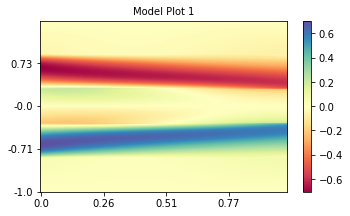

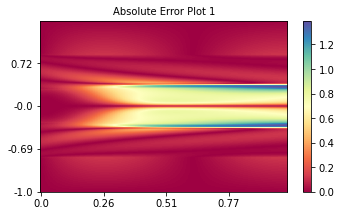

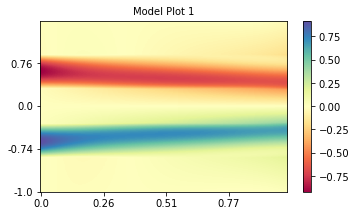

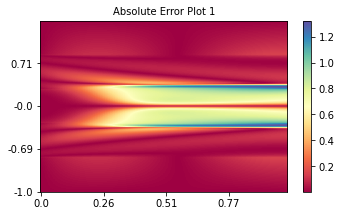

In [20]:
_ = bm_l2.eval_model()
bm_l2.plot_model(prefix=prefix)
bm_l2.plot_abs_err(prefix=prefix)

_ = bm_.eval_model()
bm_.plot_model(prefix=prefix)
bm_.plot_abs_err(prefix=prefix)

_ = bm_s.eval_model()
bm_s.plot_model(prefix=prefix)
bm_s.plot_abs_err(prefix=prefix)

_ = bm_mod.eval_model()
bm_mod.plot_model(prefix=prefix)
bm_mod.plot_abs_err(prefix=prefix)

_ = bm_s_mod.eval_model()
bm_s_mod.plot_model(prefix=prefix)
bm_s_mod.plot_abs_err(prefix=prefix)

#### ERROR

In [21]:
print(f'L1  Error: {bm_l2.lp_err(1, precision=3)};\
        L2  Error: {bm_l2.lp_err(2, precision=3)};\
        Max Error: {bm_l2.lp_err(np.inf, precision=3)}')

print(f'L1  Error: {bm_.lp_err(1, precision=3)};\
        L2  Error: {bm_.lp_err(2, precision=3)};\
        Max Error: {bm_.lp_err(np.inf, precision=3)}')

print(f'L1  Error: {bm_s.lp_err(1, precision=3)};\
        L2  Error: {bm_s.lp_err(2, precision=3)};\
        Max Error: {bm_s.lp_err(np.inf, precision=3)}')

print(f'L1  Error: {bm_mod.lp_err(1, precision=3)};\
        L2  Error: {bm_mod.lp_err(2, precision=3)};\
        Max Error: {bm_mod.lp_err(np.inf, precision=3)}')

print(f'L1  Error: {bm_s_mod.lp_err(1, precision=3)};\
        L2  Error: {bm_s_mod.lp_err(2, precision=3)};\
        Max Error: {bm_s_mod.lp_err(np.inf, precision=3)}')

L1  Error: ['1.852e-01'];        L2  Error: ['3.493e-01'];        Max Error: ['1.199e+00']
L1  Error: ['1.894e-01'];        L2  Error: ['3.527e-01'];        Max Error: ['1.394e+00']
L1  Error: ['6.709e-02'];        L2  Error: ['1.103e-01'];        Max Error: ['5.331e-01']
L1  Error: ['1.883e-01'];        L2  Error: ['3.509e-01'];        Max Error: ['1.324e+00']
L1  Error: ['5.542e-02'];        L2  Error: ['9.748e-02'];        Max Error: ['5.340e-01']
